<a href="https://colab.research.google.com/github/Liping-LZ/BDAO_ECDA/blob/main/Text%20analysis/Topic_Modelling_for_review_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modelling for review analysis**

Latent Dirichlet Allocation (LDA) is a classic model to do topic modelling. Topic modeling is unsupervised learning and the goal is to group different documents to the same “topic”.

## **1. import data you would like to analyse**

In [1]:
# Let's import data first
# Run the code and upload the csv file from your laptop
from google.colab import files
uploaded = files.upload()

Saving Anydo_review_new.csv to Anydo_review_new.csv


In [2]:
import pandas as pd

data = 'Anydo_review_new.csv'
df = pd.read_csv(data) # change the csv file name to your file name that you uploaded
df.head()

,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at
0,gp:AOqpTOEcWS_b8b4P2gClKovxXAPg3il0AD0ZnGw9RxY...,Unable to use it as it won't work with my Goog...,1,13,5.7.0.20,11/01/2021 01:12
1,gp:AOqpTOEidRmDaHGYPZW21SVfBkeqTruAzg7LAmCPL2_...,I downloaded this because of the cross platfor...,1,81,5.7.0.20,22/12/2020 18:31
2,gp:AOqpTOEJfVU5Os7_8CNOu_mpy2AlDz8kFxEFMeBMnxC...,I am starting to hate this app! Every time the...,1,67,5.7.0.10,02/12/2020 15:52
3,gp:AOqpTOFSPaoOVarqwKF86e7-TPUyV6BanSXKRNFGb6G...,"Liked Any.do at first, enough that I even sign...",1,102,5.7.0.10,22/11/2020 23:42
4,gp:AOqpTOEmghRiCCy0_FYbWBSoRm2ff2hzFTbEjgQ9svu...,They made me sign up for premium just to have ...,1,2,5.7.0.20,31/12/2020 01:49


In [3]:
target_column = 'content' #change the column name to where the review is

## **2. Text cleaning & Text processing**
Before you do topic modeling, you need make sure you clean and process the text.

In [4]:
!pip install contractions
import re
import string
import contractions
import nltk
import gensim
from gensim.utils import simple_preprocess
import spacy
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# drop data with missing values in the 'content' column
df = df.dropna(subset=[target_column])

# drop duplicate review content
df = df.drop_duplicates(subset=[target_column])

# remove contraction
df[target_column] = df[target_column].map(lambda x: contractions.fix(x))

# convert the relevant column to lowercase
df[target_column] = df[target_column].str.lower()

# Remove overspace
df[target_column] = df[target_column].map(lambda x: re.sub('\s{2,}', " ", x))

# Remove non-word characters, so numbers and ___ etc
df[target_column] = df[target_column].str.replace("[^A-Za-z]", " ", regex = True)

# Remove punctuation
df[target_column] = df[target_column].map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [5]:
# create a list of the contents from the 'contents' column
words = df[target_column].tolist()

# tokenise the words
word_tokens = []
for content in words:
    word_tokens.append(word_tokenize(content))

# create bigram model
bigram = gensim.models.phrases.Phrases(word_tokens, min_count=3, threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram) # Faster way to get a sentence clubbed as a trigram/bigram

# NLTK Stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['app']) #add more stopwords here

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define functions for stopwords, bigrams and lemmatisation
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove stopwords
data_words_nostops = remove_stopwords(word_tokens)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatisation keeping only noun, adj, vb, adv
data_lemmatised = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# put the tokens back together as text to have our filtered contents

rejoin = []
for content in data_lemmatised: # Here we choose to use stemming instead of lemmatisation
    x = " ".join(content) # join the text back together
    rejoin.append(x)

# add the reformed text to the data frame
df['cleaned_review'] = rejoin

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **3. Build the LDA model**

In [6]:
# vectorise the data into word counts

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

max_words = 1000 #how many words taking account for topic modeling
vectorizer = CountVectorizer(max_features=max_words)
vec = vectorizer.fit_transform(df['cleaned_review'])

k = 6 #this is the number of the topic. you can decide the number

lda = LDA(n_components=k, max_iter=5, learning_method='online', random_state = 10)
lda.fit(vec)

LatentDirichletAllocation(learning_method='online', max_iter=5, n_components=6,
                          random_state=10)

## **4. Visualisation of the topics**

Topic#  1
task,reminder,time,day,use,set,event,get,notification,work,need,date,start,make,great,still,love,even,issue,excellent,want,put,show,change,come,thing,calendar,repeat,feature,week,go,daily,find,remind,back,update,fix,option,annoying,much,good,help,many,also,easy,schedule,turn,problem,helpful,widget

Topic#  2
good,experience,add,keep,choice,application,calendar,device,great,see,icon,month,bad,update,subscription,premium,understand,productive,android,organise,clear,uninstalled,big,show,pop,app,uninstalle,still,appointment,purchase,give,thank,need,note,thing,download,look,tap,widget,put,happen,poor,try,even,list,work,text,io,annoying,advertising

Topic#  3
crash,alexa,fix,totally,spam,little,fantastic,star,user_friendly,report,total,hour,uninstall,job,get,gtd,expensive,person,well,todo_list,big,interval,guy,useless,page,issue,open,time,respond,planner,year,install,please,plan,user,sync,buy,base,care,think,regard,busy,menu,several,rubbish,next,bit,true,favorite,feature

Topic#  4

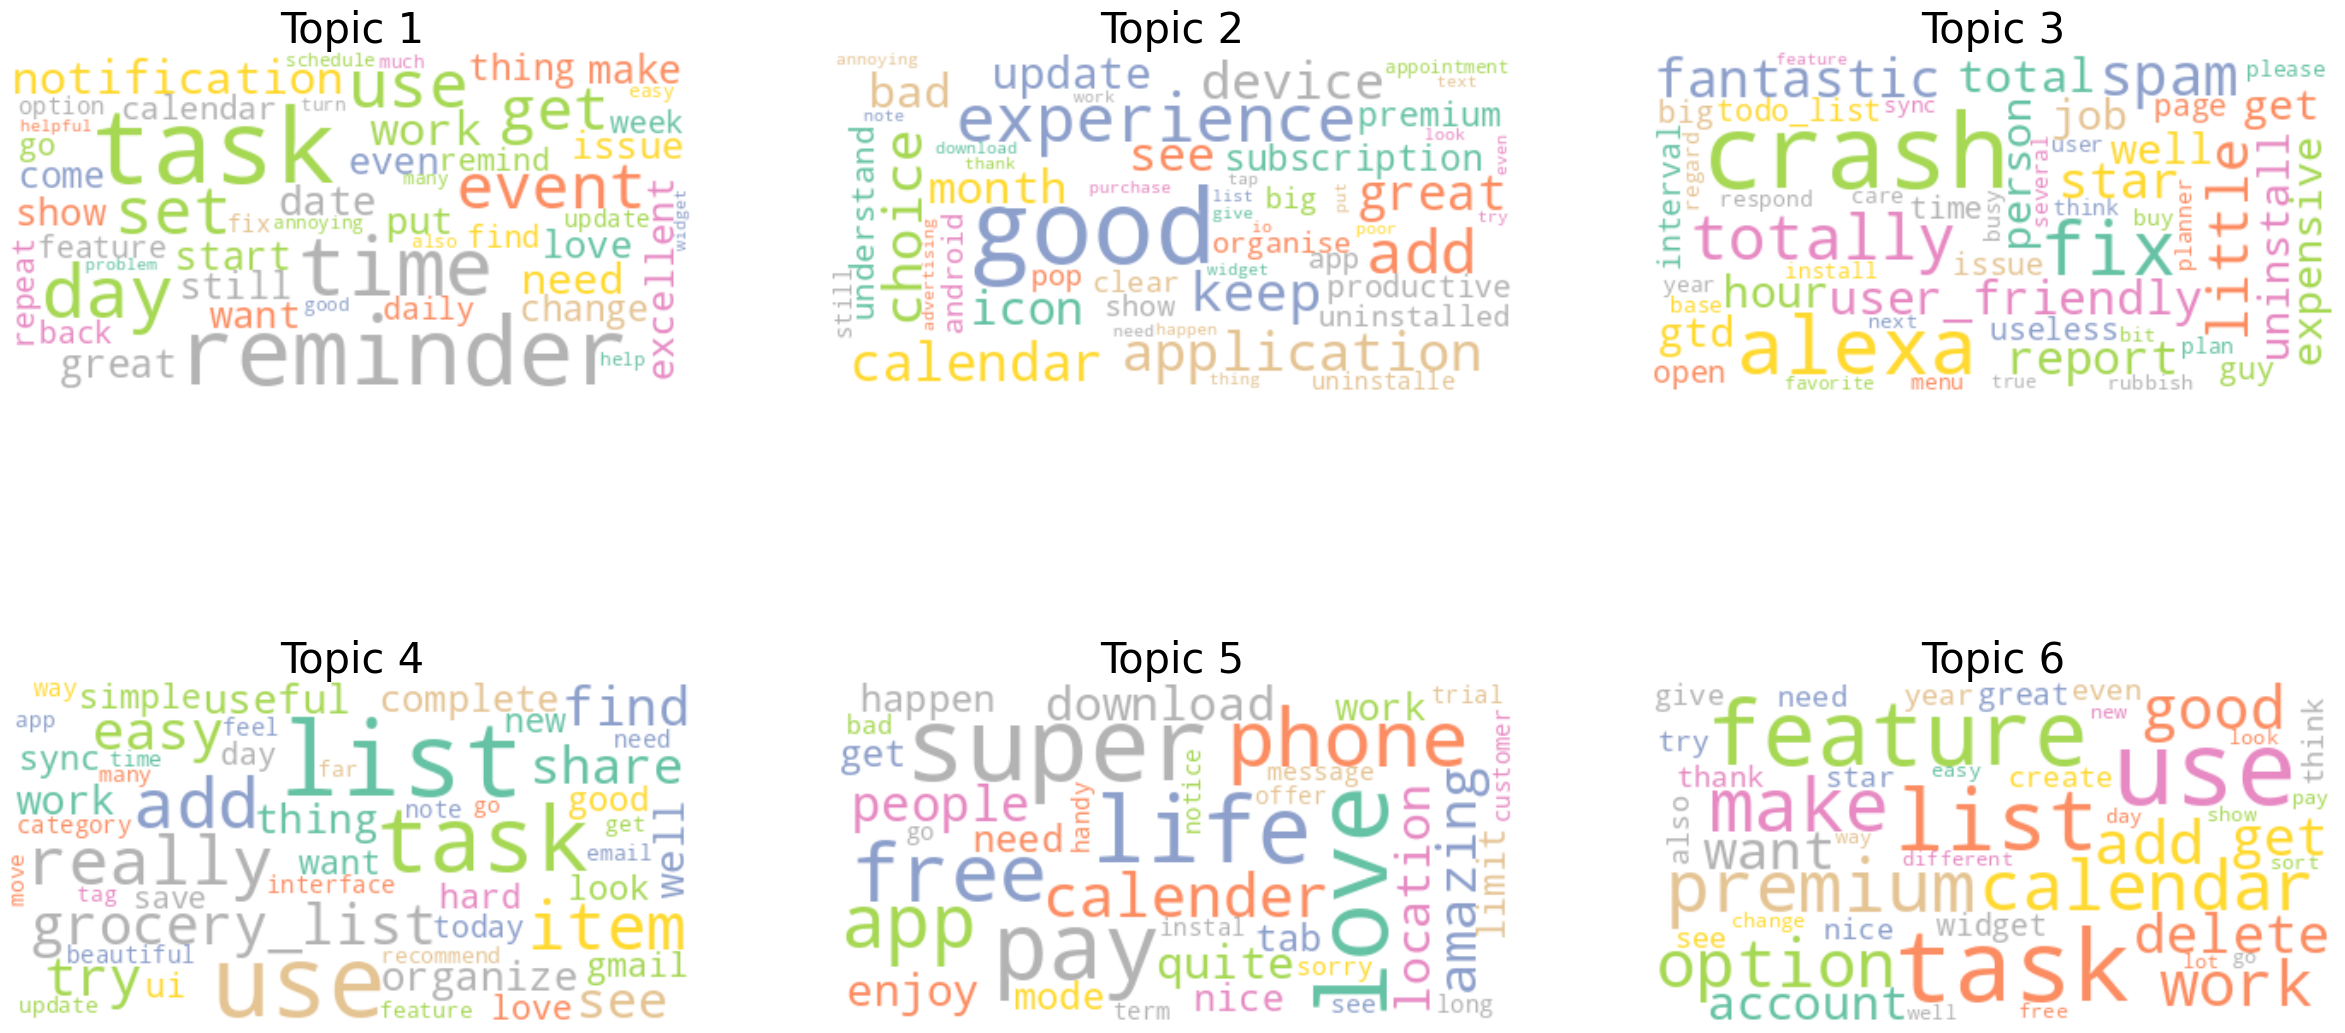

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import wordcloud

#declaring number of terms we need per topic
terms_count = 50

terms = vectorizer.get_feature_names_out()

wcloud = wordcloud.WordCloud(background_color="White",mask=None, max_words=100,\
                             max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
                             contour_width=3,contour_color='Black',colormap='Set2')

fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
axes = axes.flatten()

for idx,topic in enumerate(lda.components_):
    print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
    print(','.join( word for word in topic_words))
    print("")
    dict_word_frequency = {}

    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]

    ax = axes[idx]
    ax.set_title(f'Topic {idx +1}',fontdict={'fontsize': 30})
    wcloud.generate_from_frequencies(dict_word_frequency)
    ax.imshow(wcloud, interpolation='bilinear')
    ax.axis("off")

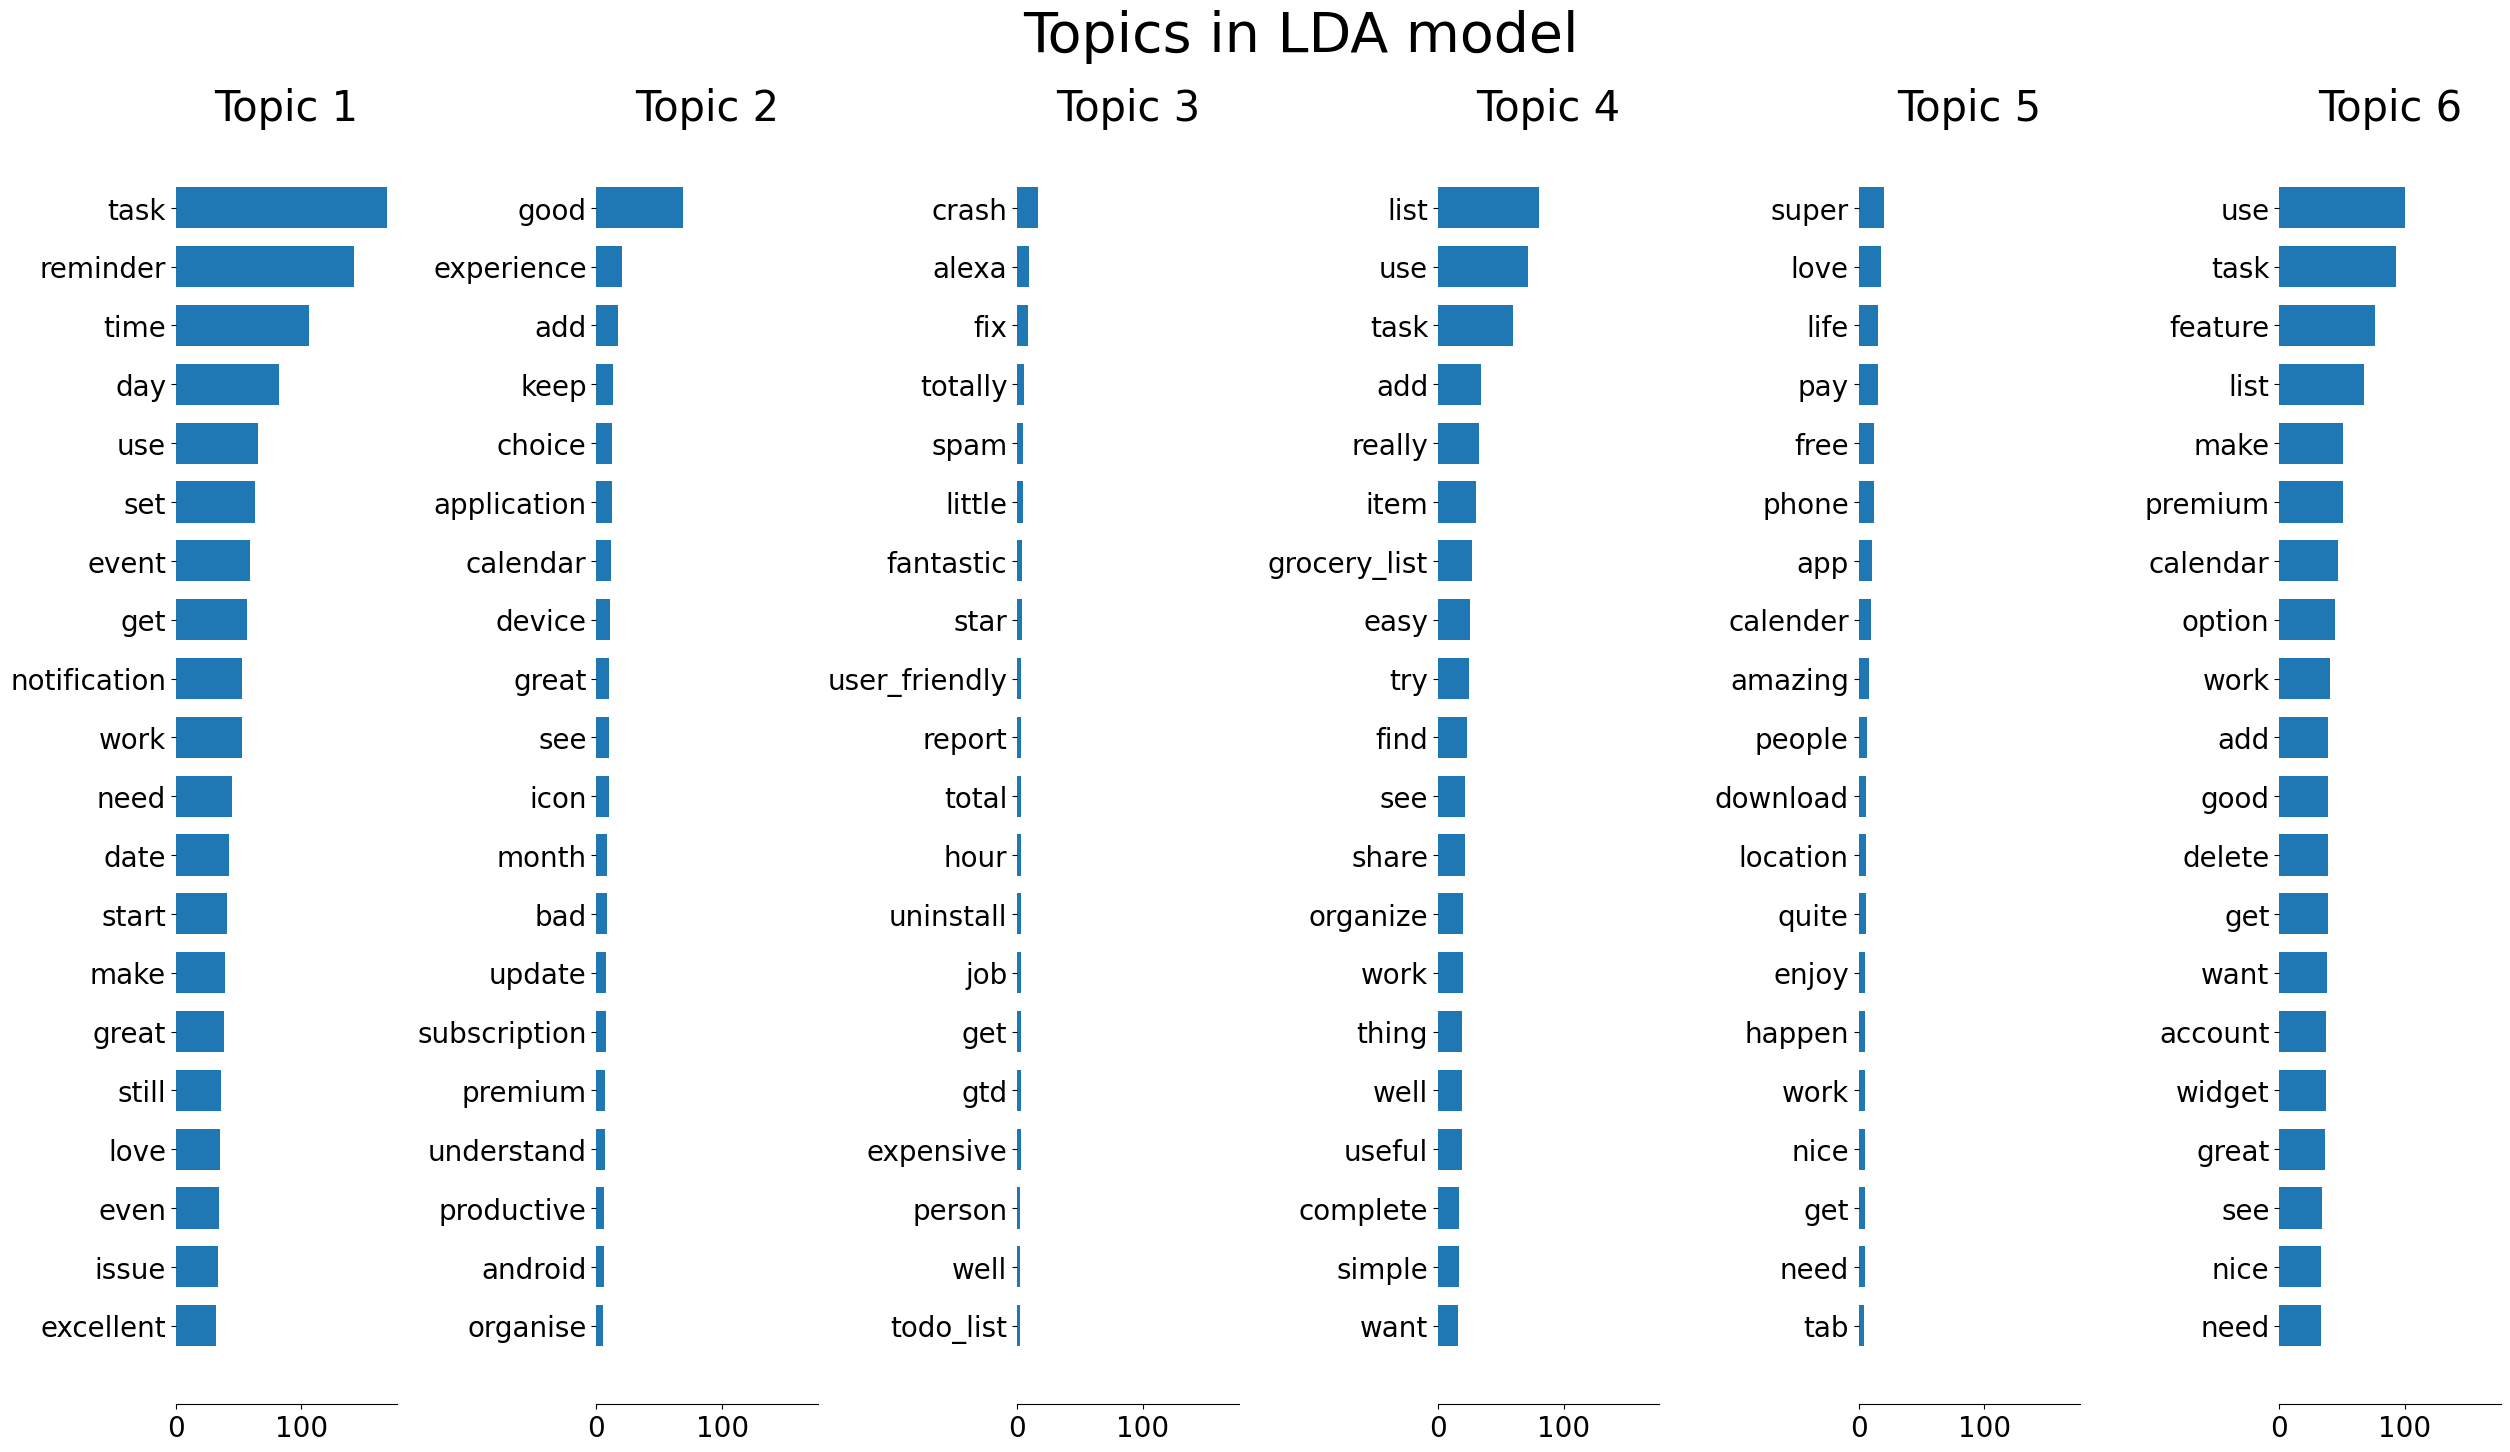

In [8]:
# Visualise the result into bar charts in topic

%matplotlib inline
import matplotlib.pyplot as plt

# helper function to plot topics
# see Grisel et al.
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 6, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20  #how many words to be visualised in each topic

# get the list of words (feature names)
vec_feature_names = vectorizer.get_feature_names_out()

# print the top words per topic
plot_top_words(lda, vec_feature_names, n_top_words, 'Topics in LDA model')

## **5. Download file with assigned topic**

In [9]:
doc_topic = lda.transform(vec)
docsVStopics = pd.DataFrame(doc_topic, columns=["Topic"+str(i+1) for i in range(k)])
df = df.join(docsVStopics)
df['mostlikely_topic'] = docsVStopics.idxmax(axis=1)

df.to_csv('topic_modeling_result.csv', index=False) # save the file to google drive
files.download('topic_modeling_result.csv') # download the file to your local machine

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>